In [1]:
import readfof
from pyspark.sql import SparkSession
import numpy as np
import scipy.spatial as SS
import matplotlib.pyplot as plt
import math

In [2]:
spark = SparkSession.builder \
        .master("spark://master:7077")\
        .appName("CosmoSparkApplication")\
        .getOrCreate()

sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/06 07:42:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Read data
def read_cosmo_data(file_path):

    # Read Fof
    FoF = readfof.FoF_catalog(
        file_path,           # simulation directory
        2,                   # snapnum, indicating the redshift (z=1)
        long_ids = False,
        swap = False,
        SFR = False,
        read_IDs = False
        )

    return FoF


# Get masses and positions from FoF
def get_pos_mass(FoF):

    pos = FoF.GroupPos/1e06             # Halo positions in Gpc/h 
    mass_raw = FoF.GroupMass * 1e10     # Halo masses in Msun/h

    dim = pos.shape[0]
    pos_mass_matrix = np.hstack([pos, mass_raw.reshape(dim, 1)])

    return pos_mass_matrix


# plot a graph in 3D space
def plot_graph_3D(num, pars_file, pos, masses, edge_idx):

    fig = plt.figure(figsize=(10, 10))
    fontsize = 12

    ax = fig.add_subplot(projection ="3d")

    pos = np.array(pos, dtype=float) * 1.e3   # show in Mpc

    # Draw lines for each edge
    for (src, dst) in edge_idx: #.t().tolist():

        src = pos[int(src)].tolist()
        dst = pos[int(dst)].tolist()

        ax.plot([src[0], dst[0]], [src[1], dst[1]], zs=[src[2], dst[2]], linewidth=0.6, color='dimgrey')

    # Plot nodes
    mass_mean = np.mean(masses)
    for i,m in enumerate(masses):
            ax.scatter(pos[i, 0], pos[i, 1], pos[i, 2], s=50*m*m/(mass_mean**2), zorder=1000, alpha=0.6, color = 'mediumpurple')

    ax.xaxis.set_tick_params(labelsize=fontsize)
    ax.yaxis.set_tick_params(labelsize=fontsize)
    ax.zaxis.set_tick_params(labelsize=fontsize)

    ax.set_xlabel('x (Mpc)', fontsize=16, labelpad=15)
    ax.set_ylabel('y (Mpc)', fontsize=16, labelpad=15)
    ax.set_zlabel('z (Mpc)', fontsize=16, labelpad=15)

    rl = '$R_{link} = 0.2$'

    pars_file = pars_file[num]

    ax.set_title(f'\tGraph n°{num}, Masses $\\geq 99.7$% percentile, {rl} Mpc \t \n \n $\\Omega_m = {float(pars_file[0]):.3f}$ \t $\\sigma_8 = {float(pars_file[1]):.3f}$', fontsize=20)

    plt.show()

def sub_box_bounds(box_number,r_link): #function that returns the partitions bounds as a dictionary of lists of tuples, each tuple being the min and max of a dimension
    sub_length=1.0/box_number #partition length
    bounds={}
    base='box'
    sub_box_counter=1
    for x in range(0,box_number):
        for y in range(0,box_number):
            for z in range(0,box_number):
                key=base+str(sub_box_counter)
                single_bounds=[]
                centre=[x,y,z] #vertex of a sub_box corresponding to min x,y,z
                for i in range(3):
                    min_bound=round(max(0,centre[i]*sub_length-0.5*r_link),2)
                    max_bound=round(min(1,centre[i]*sub_length+sub_length+0.5*r_link),2)
                    single_bounds.append((min_bound,max_bound))
                bounds[key]=single_bounds
                sub_box_counter+=1

    return bounds

# Assign each point to a box
def assign_box(point, boxes):
    x, y, z = point[0]
    box_assign = []
    
    for box_name, ((x_min, x_max), (y_min, y_max), (z_min, z_max)) in boxes.items():
     if (x_min <= x <= x_max) and (y_min <= y <= y_max) and (z_min <= z <= z_max):
           box_assign.append((box_name, point))
    
    return box_assign

# Graph object
class graph:

    def __init__(self, node_f, pos, sim_pars, glob_f, edge_idx, edge_f):
        
        self.node_f = node_f
        self.pos = pos
        self.sim_pars = sim_pars
        self.glob_f = glob_f
        self.edge_idx = edge_idx
        self.edge_f = edge_f

In [19]:
# simulations parameter
sim_pars_file = np.loadtxt("/mnt/cosmo_GNN/latin_hypercube_params.txt", dtype=float)

# read file and get positions and masses
file_path = "/mnt/cosmo_GNN/Data/" + str(8)
test_FoF = read_cosmo_data(file_path)
pos_mass_array = get_pos_mass(test_FoF)

# mass cut
cut = np.quantile(pos_mass_array[:, 3], 0.997)

# parallelize and filter by mass
pos_mass_rdd = sc.parallelize(pos_mass_array)\
                 .filter(lambda el: el[3] >= cut)
pos_mass_rdd.take(3)

[array([7.7525789e-01, 1.4784946e-01, 4.6089169e-01, 7.2134815e+14],
       dtype=float32),
 array([6.1568999e-01, 3.9869353e-01, 7.9261804e-01, 5.5314266e+14],
       dtype=float32),
 array([9.8808074e-01, 9.5635426e-01, 2.7730331e-01, 5.4184032e+14],
       dtype=float32)]

In [20]:
boxes = sub_box_bounds(2,0.2)

In [21]:
mass_rdd = pos_mass_rdd.map(lambda x: x[3])
mass_rdd.take(3)

[np.float32(721348150000000.0),
 np.float32(553142660000000.0),
 np.float32(541840320000000.0)]

In [22]:
# positions rddc
pos_rdd = pos_mass_rdd.map(lambda el: el[:3])
pos_rdd.take(3)

[array([0.7752579 , 0.14784946, 0.4608917 ], dtype=float32),
 array([0.61569   , 0.39869353, 0.79261804], dtype=float32),
 array([0.98808074, 0.95635426, 0.2773033 ], dtype=float32)]

In [23]:
# indexed position rdd
idx_pos_rdd = pos_rdd.zipWithIndex()
idx_pos_rdd.take(3)

[(array([0.7752579 , 0.14784946, 0.4608917 ], dtype=float32), 0),
 (array([0.61569   , 0.39869353, 0.79261804], dtype=float32), 1),
 (array([0.98808074, 0.95635426, 0.2773033 ], dtype=float32), 2)]

In [24]:
idx_pos_box_rdd = idx_pos_rdd.flatMap(lambda p: assign_box(p, boxes))
idx_pos_box_rdd.take(2)

[('box5', (array([0.7752579 , 0.14784946, 0.4608917 ], dtype=float32), 0)),
 ('box6', (array([0.7752579 , 0.14784946, 0.4608917 ], dtype=float32), 0))]

In [10]:
#cartesian_rdd = boxes_rdd.cartesian(boxes_rdd)


#cartesian_rdd = idx_pos_box_rdd.cartesian(idx_pos_box_rdd)\
#                                .filter(lambda x: x[0][0]==x[1][0])

grouped_rdd = idx_pos_box_rdd.groupByKey()

# For each key, compute the Cartesian product within the group
cartesian_rdd = grouped_rdd.flatMapValues(lambda points: [(p1,p2) for p1 in points for p2 in points])\
                        .map(lambda x: ((x[0], x[1][0]),(x[0], x[1][1])))


In [25]:
grouped_rdd.take(3)

[('box5', <pyspark.resultiterable.ResultIterable at 0x7f7a7e23ff20>),
 ('box6', <pyspark.resultiterable.ResultIterable at 0x7f7a81828980>),
 ('box7', <pyspark.resultiterable.ResultIterable at 0x7f7a7e037320>)]

In [26]:
cartesian_rdd.take(3)

[(('box5', (array([0.7752579 , 0.14784946, 0.4608917 ], dtype=float32), 0)),
  ('box5', (array([0.7752579 , 0.14784946, 0.4608917 ], dtype=float32), 0))),
 (('box5', (array([0.7752579 , 0.14784946, 0.4608917 ], dtype=float32), 0)),
  ('box5', (array([0.41980904, 0.43165922, 0.04384769], dtype=float32), 14))),
 (('box5', (array([0.7752579 , 0.14784946, 0.4608917 ], dtype=float32), 0)),
  ('box5', (array([0.5094313 , 0.14071   , 0.12580945], dtype=float32), 15)))]

In [27]:
diff_rdd = cartesian_rdd.map(lambda x:(x[0][0],(x[0][1][1], x[1][1][1], np.abs(x[0][1][0] - x[1][1][0]))))
diff_rdd.take(3)

[('box5', (0, 0, array([0., 0., 0.], dtype=float32))),
 ('box5', (0, 14, array([0.35544884, 0.28380978, 0.417044  ], dtype=float32))),
 ('box5', (0, 15, array([0.26582658, 0.00713946, 0.33508223], dtype=float32)))]

In [28]:
pairs_dist_rdd = diff_rdd.mapValues(lambda x: (x[0], x[1], np.linalg.norm(x[2])))
pairs_dist_rdd.take(3)

[('box5', (0, 0, np.float32(0.0))),
 ('box5', (0, 14, np.float32(0.6171042))),
 ('box5', (0, 15, np.float32(0.42777896)))]

In [29]:
linked_pairs_dist_rdd = pairs_dist_rdd.filter(lambda x: x[1][2] <= 0.2)
linked_pairs_dist_rdd.take(3)

[('box5', (0, 0, np.float32(0.0))),
 ('box5', (0, 22, np.float32(0.13359493))),
 ('box5', (0, 24, np.float32(0.12099926)))]

In [14]:
pairs_rdd = linked_pairs_dist_rdd.mapValues(lambda x: (x[0], x[1]))
distances_rdd = linked_pairs_dist_rdd.mapValues(lambda x: x[2])

In [30]:
pairs_rdd.take(3)

[('box5', (0, 0)), ('box5', (0, 22)), ('box5', (0, 24))]

In [31]:
distances_rdd.take(3)

[('box5', np.float32(0.0)),
 ('box5', np.float32(0.13359493)),
 ('box5', np.float32(0.12099926))]

In [32]:
pairs_array = np.array(pairs_rdd.map(lambda x: x[1]).distinct().collect())
distances_array = distances_rdd.map(lambda x: x[1]).collect()
pos_rdd_plot = pos_rdd.collect()
mass_rdd_plot = mass_rdd.collect()

In [16]:
pairs_array.shape

(6734, 2)

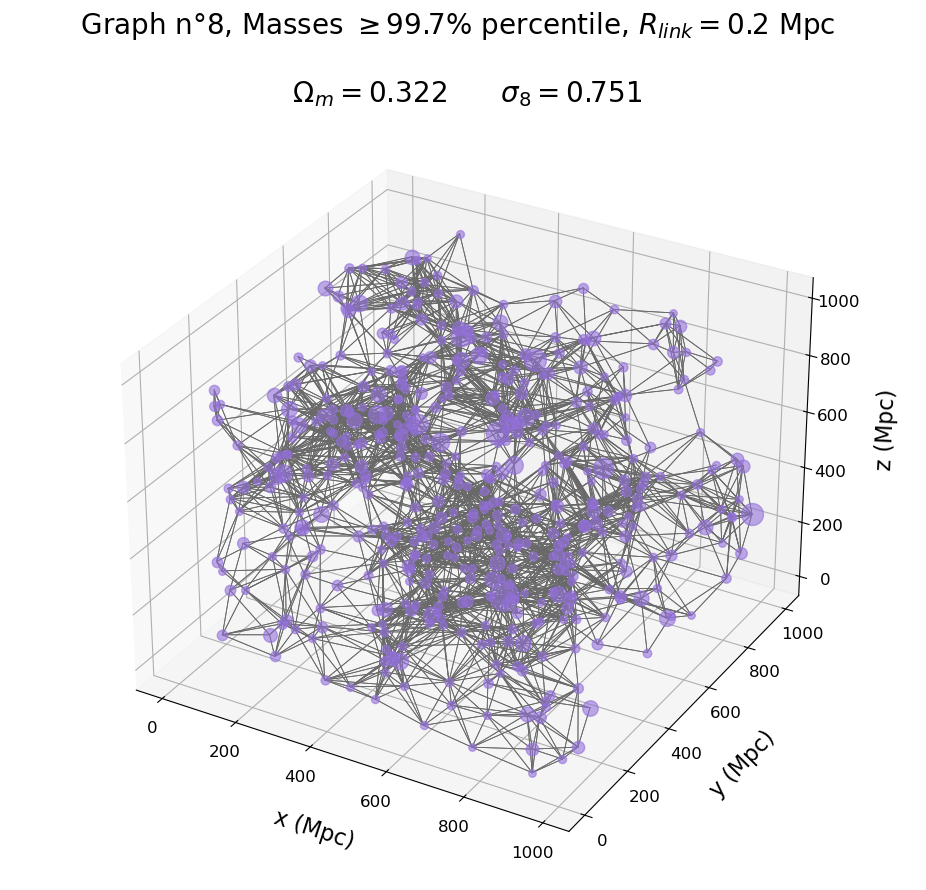

In [17]:
plot_graph_3D(8, sim_pars_file, pos_rdd_plot, mass_rdd_plot, pairs_array)

In [1]:
sc.stop()
spark.stop()

NameError: name 'sc' is not defined